Train an RNN to perform go-No go task.
TO DO: 
* Learned h0?
* analysis: connectivity and activity correlation
* include input weights and other parameters
* More complicated version of the task (noise, delay)

In [1]:
import sys
sys.path.append("../src")
import rnn
import jax.numpy as np
from jax import random
import matplotlib.pyplot as plt
%matplotlib inline
from jax.experimental import optimizers
import time

/home/joram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
key = random.PRNGKey(0)
N = 200
T = 100
params = rnn.random_vrnn_params(key, N, 1)

/home/joram/repos/jax/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# Generate random go / no go patters
keys = random.split(key, 4)
I_go = random.normal(keys[1], shape=(N, ))
I_nogo = random.normal(keys[2], shape=(N, ))

In [4]:
zN = np.zeros((25, N))
z1 = np.zeros((25, 1))

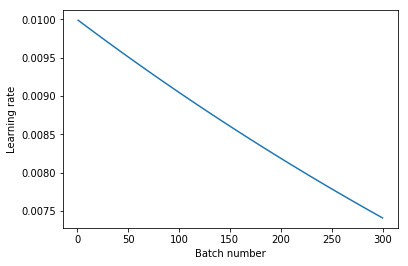

In [5]:
# Create a decay function for the learning rate
step_size = 0.01
decay_factor =0.999
import numpy as onp
num_batchs = 300
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

In [6]:
opt_init, opt_update = optimizers.adam(decay_fun)
init_params = rnn.random_vrnn_params(key, 200, 1)
batch_size = 1
opt_state = opt_init(init_params)
l2reg = 0

all_train_losses = []
start_time = time.time()
for batch in range(num_batchs):
    key, subkey = random.split(key)
    label = random.randint(key, minval=0, maxval=2, shape=(1,))
    if label == 1:
        inputs = np.concatenate((zN, np.repeat(I_go[None], 50, 0), zN))
        targets = np.concatenate((z1, np.ones((50,1)), z1))
    else:
        inputs = np.concatenate((zN, np.repeat(I_nogo[None], 50, 0), zN))
        targets = np.concatenate((z1, np.zeros((50,1)), z1))
    inputs = inputs[None]
    targets = targets[None]
    opt_state = rnn.update_w_gc_jit(1, opt_state, opt_update, inputs,
                                  targets, 10, 0)
    
    if batch % 10 == 0:
        params = optimizers.get_params(opt_state)
        all_train_losses.append(rnn.loss_jit(params, inputs, targets, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 29.28 sec, step size: 0.01000, training loss 9.5580
Batch 10 in 0.47 sec, step size: 0.00990, training loss 0.1476
Batch 20 in 0.47 sec, step size: 0.00980, training loss 0.0618
Batch 30 in 0.45 sec, step size: 0.00970, training loss 0.0086
Batch 40 in 0.47 sec, step size: 0.00961, training loss 0.0086
Batch 50 in 0.46 sec, step size: 0.00951, training loss 0.0036
Batch 60 in 0.48 sec, step size: 0.00942, training loss 0.0010
Batch 70 in 0.47 sec, step size: 0.00932, training loss 0.0044
Batch 80 in 0.48 sec, step size: 0.00923, training loss 0.0019
Batch 90 in 0.44 sec, step size: 0.00914, training loss 0.0012
Batch 100 in 0.43 sec, step size: 0.00905, training loss 0.0004
Batch 110 in 0.43 sec, step size: 0.00896, training loss 0.0002
Batch 120 in 0.44 sec, step size: 0.00887, training loss 0.0001
Batch 130 in 0.44 sec, step size: 0.00878, training loss 0.0002
Batch 140 in 0.44 sec, step size: 0.00869, training loss 0.0000
Batch 150 in 0.46 sec, step size: 0.00861, trainin

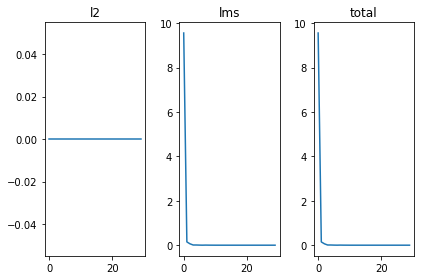

In [7]:
f, ax = plt.subplots(1,3)
for i, key in enumerate(all_train_losses.keys()):
    ax[i].plot(all_train_losses[key])
    ax[i].set_title(key)
f.tight_layout()

## Predictions

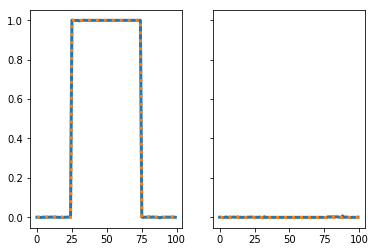

In [26]:
# Predictions: go
params = optimizers.get_params(opt_state)
inputs = np.concatenate((zN, np.repeat(I_go[None], 50, 0), zN))
targets = np.concatenate((z1, np.ones((50,1)), z1))
inputs = inputs[None]
targets = targets[None]
ht, ot = rnn.batched_rnn_run(params, inputs)
f, ax = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].plot(ot[0].flatten(), lw=3)
ax[0].plot(targets.flatten(),":", lw=3)

# Predictions: no go
params = optimizers.get_params(opt_state)
inputs = np.concatenate((zN, np.repeat(I_nogo[None], 50, 0), zN))
targets = np.concatenate((z1, np.zeros((50,1)), z1))
inputs = inputs[None]
targets = targets[None]
ht, ot = rnn.batched_rnn_run(params, inputs)
ax[1].plot(ot[0].flatten(), lw=3)
ax[1].plot(targets.flatten(),":", lw=3)

0.05503038530625391


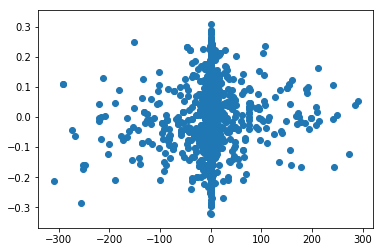

In [28]:
# Select Go trials, during stimulus
params = optimizers.get_params(opt_state)
inputs = np.concatenate((zN, np.repeat(I_go[None], 50, 0), zN))
targets = np.concatenate((z1, np.ones((50,1)), z1))
inputs = inputs[None]
targets = targets[None]
ht, ot = rnn.batched_rnn_run(params, inputs)
X = ht[:,25:75].mean(0) # 5 * T * N -> T * N
J2 = params['wR']
from sklearn.decomposition import PCA
pca= PCA(n_components=1)
X_red = pca.fit_transform(X) #(T *1)
# get coefs on first PC (25) 
coefs = np.dot(X_red.T, X) 
# Correlation between PC 1coefs
C = np.tril(np.dot(coefs.T, coefs),1)
x =C[np.abs(C)>0]
y = J2[np.abs(C)>0]
# random selection for plotting
idx = onp.random.choice(np.arange(x.shape[0]), size=(5000, ))
plt.scatter(x[idx], y[idx])
print(onp.corrcoef(x,y)[0,1])

0.17547372614938


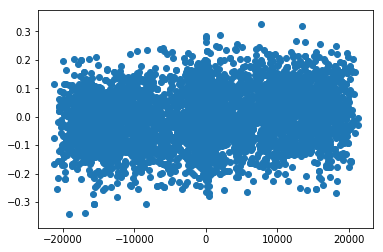

In [29]:
# Select Go trials, during stimulus
params = optimizers.get_params(opt_state)
inputs = np.concatenate((zN, np.repeat(I_nogo[None], 50, 0), zN))
targets = np.concatenate((z1, np.zeros((50,1)), z1))
inputs = inputs[None]
targets = targets[None]
ht, ot = rnn.batched_rnn_run(params, inputs)
X = ht[:,25:75].mean(0) # 5 * T * N -> T * N
J2 = params['wR']
from sklearn.decomposition import PCA
pca= PCA(n_components=1)
X_red = pca.fit_transform(X) #(T *1)
# get coefs on first PC (25) 
coefs = np.dot(X_red.T, X) 
# Correlation between PC 1coefs
C = np.tril(np.dot(coefs.T, coefs),1)
x =C[np.abs(C)>0]
y = J2[np.abs(C)>0]
# random selection for plotting
idx = onp.random.choice(np.arange(x.shape[0]), size=(5000, ))
plt.scatter(x[idx], y[idx])
print(onp.corrcoef(x,y)[0,1])